## Spam Detection
The purpose of this ipython note book is to: 
1. Use Latent Semantic Indexing to reduce a training set of text messages
2. Use Linear Discriminant Analysis to predict "topics" into spam or ham (1 or 0)
3. Do exploratory data analysis to inform tuning
4. Use results to predict on test, validation, external datasets
5. tune model for highest performance (based on accuracy, precision, and recall)

#### Importing Libraries and Modules

In [48]:
import pandas as pd
import numpy as np 
import warnings
import gensim as gs
import nltk 
from re import sub # import sub to replace items in the followiong list comprehension
from collections import defaultdict
from sklearn.lda import LDA
import matplotlib.pyplot as plt
import re
from scipy.stats import ttest_ind
from sklearn import linear_model
import seaborn as sns; sns.set(color_codes=True)

warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
%matplotlib inline

#### 1. Read Data:
1. Read Spam data
2. Read personal text messages

In [47]:
# Data of Spam and non spam data from UC Irvine's Spam Repository
data = pd.read_table('SMSSpamCollection',header= None, names = ('outcome', 'content'))
# Read my personal text messages 
new_doc = ["hey dude where are you", "text 444 for a promotional treat", "dont know what time it is", "Our records indicate your Pension is under performing to see higher growth and up to 25% cash release reply PENSION for a free review. To opt out reply STOP",           "To start the process please reply YES. To opt out text STOP", "i'm going to be 10 mins late"]
new_doc_results = ['ham','spam','ham','spam','spam','ham']

# Stop words
stopwords_set1 = set(nltk.corpus.stopwords.words('english'))
stopwords_set2 = set('for a of the and to in or'.split())
stopwords_set3 = ''
symbol_removed1 = '[^A-Za-z0-9]+'

#### 2. Data Preprocessing
1. Split Train, Test, Validate
2. This function will apply stopwords and remove symbols. There are two sets of stopwords and one symbol set. 

In [49]:
# 1. Split Data into 
n = 3000
train = data.sample(n, random_state = 111)
test = data[~data.index.isin(train.index)]
validate = test.sample(1000,random_state = 111)
test= test[~test.index.isin(validate.index)]
split_correctly = 0 == sum(validate.index.isin(test.index)) + sum(test.index.isin(train.index)) + sum(validate.index.isin(train.index))
set_n_sizes = 'N\'s in .. train:', train.shape,'test:', test.shape,'validate:', validate.shape
print('Data Split Correct?', split_correctly, '\n'*2, set_n_sizes)

Data Split Correct? True 

 ("N's in .. train:", (3000, 2), 'test:', (1572, 2), 'validate:', (1000, 2))


In [21]:
# 2. Prep Data
def prep_nlp(data_to_prep, stop_words_in, symbols_to_remove):
    # lower case it
    clean = list(data_to_prep.str.lower())
    # this will tokenize
    clean = [[word for word in document.split()] for document in clean]
    words_to_remove = '|'.join(stop_words_in)
    symbol_remover = '[^A-Za-z0-9]+'
    clean = [[sub(symbol_remover,'',word) for word in text] for text in clean]
    clean = [[sub(words_to_remove,'',word) for word in text] for text in clean]
    return clean

#### 3.  Data Exploration /  Feature Selection
[Contents Located Here](https://github.com/chrisgian/SB8-Statistical-Inference/blob/master/8.6%20-%20inference%20on%20capstone/8.6%20Apply%20inferential%20statistics%20to%20Capstone%20Project.ipynb) 

#### 4. Build unsupervised Model
1. Build term frequencies.
2. Build dictionray using term frequencies
3. Build Corpus /  bag of words 
4. Create term frequency inverse document frequency matrix
5. Reduce matrix into 300 topics (dimension reduction)

In [50]:
def build_model(train_data, topic_n):
    frequency = defaultdict(int)
    for text in train_data:
        for token in text:
            frequency[token] += 1
    # get freq > 1
    word_freq_1plus = [[x for x in words if frequency[x] > 1] for words in train_data]
    # Create dictionary
    dictionary = gs.corpora.Dictionary(word_freq_1plus)
    # Create Corpus
    corpus = [dictionary.doc2bow(text) for text in train_data]
    # corpus to tfidf
    tfidf = gs.models.TfidfModel(corpus) 
    corp_tf = tfidf[corpus] 
    # Unsupervised Component. Reduce space into 300 topics. 
    topic_n = topic_n
    lsi = gs.models.LsiModel(corp_tf, id2word=dictionary, num_topics = topic_n)
    corp_topics = lsi[corp_tf] 
    return corp_topics, dictionary, tfidf, lsi    

#### 5. Build supervised Model
Take the unsupervised results from LSI (a matrix of 300 topics). Train against outcome variable "Spam" or "Ham" (1 or 0). 
Use Linear Discriminant Analysis to fit data. 

In [51]:
def train_model(topic_vec):
    x = pd.DataFrame([dict(row) for row in topic_vec[0]])
    y = (train["outcome"] == "spam").astype(int) 
    lda = LDA()
    mask = np.array([~np.isnan(row).any() for row in x.values])
    x_masked = x[mask]
    y_masked = y[mask]
    lda = lda.fit(x_masked,y_masked)
    return lda,x_masked,y_masked, topic_vec[1],topic_vec[2], topic_vec[3]

#### 6. Test Model on Unseen Data
This sets up the function "Predict Unseen" which takes documents which were not in the origial training set. This can be used for validation data, test, or any additional documents. The following steps are applied:
1. Run the new documents through the same preparation steps as training. 
2. Create bag of words with new data
3. Transform into term-frequency, inverse document frequency matrix
4. Apply results from latent semantic indexing and remove missing values
5. Predict classes based on LSI results into class "Spam" or "Ham" (1 or 0)

In [52]:
def predict_unseen(new_doc_in, stop_words_in, trained_model_in, symbols_to_remove):

    dictionary_in = trained_model_in[3]
    tfidf_in = trained_model_in[4]
    lsi_in = trained_model_in[5]
    lda_in = trained_model_in[0]
    new_doc_in_content = pd.Series(new_doc_in.content)
    new_doc_in_outcome = pd.Series(new_doc_in.outcome)
    
    query = prep_nlp(new_doc_in_content, stop_words_in, symbols_to_remove)
    query_bow = [dictionary_in.doc2bow(corp) for corp in query]
    query_tf = tfidf_in[query_bow] 
    
    x_2 = pd.DataFrame([dict(tf) for tf in lsi_in[query_tf]])
    mask = np.array([~np.isnan(row).any() for row in x_2.values])
    x_2masked = x_2[mask]
    y_2 = (new_doc_in_outcome == "spam").astype(int) 
    
    y_2masked = np.array(y_2[mask])
    x_2masked = lda_in.predict(x_2masked)
    
    return x_2masked,y_2masked

##### 7.Performance
There are three performance metrics:
1. "Accuracy" which tells us, what percent of predicted results equal the actual results
2. "Precision": Of all all observations we predicted as spam, what is actually spam?
3. "Recall": Of all observations actually spam, what percent did we predict?

In [53]:
def performance(result_x, result_y):
    actual_positive = result_y == 1
    actual_negative = result_y ==0
    true_positives = result_x[actual_positive] == 1
    false_positives = result_x[actual_negative] == 1
    true_negatives = result_x[actual_negative] == 0
    false_negatives = result_x[actual_positive] == 0
    #A. Accuracy = (TP + TN)/(TP + TN + FP + FN)
    #B. Precision = TP/(TP + FP)
    #C. Recall = TP/(TP + FN)
    accuracy = sum((result_x == result_y))/len(result_y)
    precision = sum(true_positives) / (sum(true_positives) + sum(false_positives))
    recall = sum(true_positives) / (sum(true_positives) + sum(false_negatives))
    return [accuracy, precision, recall, len(result_x)]

#### 8. Execute Models

1. Run Prep Model  
2. Build unsupervised model  
3. Fit Model 

In [54]:
train_prepped = prep_nlp(
    data_to_prep = train.content,
    stop_words_in= stopwords_set2,
    symbols_to_remove=symbol_removed1)
built_model = build_model(
    train_data = train_prepped,
    topic_n = 300)
trained_model = train_model(
    topic_vec = built_model)

In [55]:
performance_on_train = performance(
    result_x=trained_model[0].predict(trained_model[1]),
    result_y=np.array(trained_model[2]))
predicted_validate = predict_unseen(
    new_doc_in=validate,
    stop_words_in = stopwords_set2,
    symbols_to_remove = stopwords_set2,
    trained_model_in = trained_model)
performance_on_validate = performance(
    result_x=predicted_validate[0],
    result_y=predicted_validate[1])


In [56]:
results_out = pd.DataFrame({
    'Train':performance_on_train,
    'Validate':performance_on_validate
}).set_index(
    [['Accuracy','Precision','Recall','N Size'],
     ['% Spam / Ham Correct','% Predicted Spam Actually Spam','% Spam Detected','']])
results_out

,,Train,Validate
Accuracy,% Spam / Ham Correct,0.980628,0.969819
Precision,% Predicted Spam Actually Spam,0.981030,0.952000
Recall,% Spam Detected,0.876513,0.832168
N Size,,2994.000000,994.000000


#### 8. Parameter Tuning
##### Different Stopword Lists
Goal: Find out how different stopwords lists affect accuracy.

In [57]:
train_prepped1_w = prep_nlp(data_to_prep = train.content,stop_words_in= stopwords_set1,symbols_to_remove=stopwords_set3)
train_prepped2_w = prep_nlp(data_to_prep = train.content,stop_words_in= stopwords_set2,symbols_to_remove=stopwords_set3)
train_prepped3_w = prep_nlp(data_to_prep = train.content,stop_words_in= stopwords_set3,symbols_to_remove=stopwords_set3)
built_model1_w = build_model(train_data = train_prepped1_w,topic_n = 300)
built_model2_w = build_model(train_data = train_prepped2_w,topic_n = 300)
built_model3_w = build_model(train_data = train_prepped3_w,topic_n = 300)
trained_model1_w = train_model(topic_vec = built_model1_w)
trained_model2_w = train_model(topic_vec = built_model2_w)
trained_model3_w = train_model(topic_vec = built_model3_w)
predicted_test1_w = predict_unseen(new_doc_in=validate,stop_words_in = stopwords_set1,symbols_to_remove = symbol_removed1,trained_model_in = trained_model1_w)
predicted_test2_w = predict_unseen(new_doc_in=validate,stop_words_in = stopwords_set2,symbols_to_remove = symbol_removed1,trained_model_in = trained_model2_w)
predicted_test3_w = predict_unseen(new_doc_in=validate,stop_words_in = stopwords_set3,symbols_to_remove = symbol_removed1,trained_model_in = trained_model3_w)

In [77]:
train_prepped1 = prep_nlp(data_to_prep = train.content,stop_words_in= stopwords_set1,symbols_to_remove=symbol_removed1)
train_prepped2 = prep_nlp(data_to_prep = train.content,stop_words_in= stopwords_set2,symbols_to_remove=symbol_removed1)
train_prepped3 = prep_nlp(data_to_prep = train.content,stop_words_in= stopwords_set3,symbols_to_remove=symbol_removed1)
built_model1 = build_model(train_data = train_prepped1,topic_n = 300)
built_model2 = build_model(train_data = train_prepped2,topic_n = 300)
built_model3 = build_model(train_data = train_prepped3,topic_n = 300)
trained_model1 = train_model(topic_vec = built_model1)
trained_model2 = train_model(topic_vec = built_model2)
trained_model3 = train_model(topic_vec = built_model3)
predicted_test1 = predict_unseen(new_doc_in=validate,stop_words_in = stopwords_set1,symbols_to_remove = symbol_removed1,trained_model_in = trained_model1)
predicted_test2 = predict_unseen(new_doc_in=validate,stop_words_in = stopwords_set2,symbols_to_remove = symbol_removed1,trained_model_in = trained_model2)
predicted_test3 = predict_unseen(new_doc_in=validate,stop_words_in = stopwords_set3,symbols_to_remove = symbol_removed1,trained_model_in = trained_model3)
results_out = pd.DataFrame({
    'NLTK Stopwords, w/o symbols':performance(result_x=predicted_test1[0], result_y=predicted_test1[1]),
    'NLTK Stopwords, w/ symbols':performance(result_x=predicted_test1_w[0], result_y=predicted_test1_w[1]),
    'Custom Stopwords, w/o symbols':performance(result_x=predicted_test2[0], result_y=predicted_test2[1]),
    'Custom Stopwords, w/ symbols':performance(result_x=predicted_test2_w[0], result_y=predicted_test2_w[1]),
    'None Removed, w/o symbols':performance(result_x=predicted_test3[0], result_y=predicted_test3[1]),
    'None Removed, w/ symbols':performance(result_x=predicted_test3_w[0], result_y=predicted_test3_w[1])
    
    
}).set_index(
    [['Accuracy','Precision','Recall','N Size'],
     ['% Spam / Ham Correct','% Predicted Spam Actually Spam','% Spam Detected','']])
results_out

,,"Custom Stopwords, w/ symbols","Custom Stopwords, w/o symbols","NLTK Stopwords, w/ symbols","NLTK Stopwords, w/o symbols","None Removed, w/ symbols","None Removed, w/o symbols"
Accuracy,% Spam / Ham Correct,0.968813,0.971831,0.960961,0.966967,0.970825,0.971831
Precision,% Predicted Spam Actually Spam,0.930769,0.952756,0.912698,0.929688,0.967213,0.967480
Recall,% Spam Detected,0.846154,0.846154,0.804196,0.832168,0.825175,0.832168
N Size,,994.000000,994.000000,999.000000,999.000000,994.000000,994.000000


##### Tuning Number of Topics
Goal: Identify how different number of topics impact performance metrics

In [9]:
def model_at_topic_i(topic_i):
    built_model = build_model(train_data = train_prepped, topic_n = topic_i)
    trained_model = train_model(topic_vec  = built_model)
    predicted_test = predict_unseen(new_doc_in=validate, stop_words_in = stopwords_set2,symbols_to_remove = symbol_removed1, trained_model_in = trained_model)
    performance_on_test = performance(result_x=predicted_test[0],result_y=predicted_test[1])
    return performance_on_test

def model_iterator(start,end):
    model_iteration = [model_at_topic_i(i) for i in range(start,end+1)]
    return model_iteration

In [113]:
topic_100_to_500 = model_iterator(start = 250, end = 500)

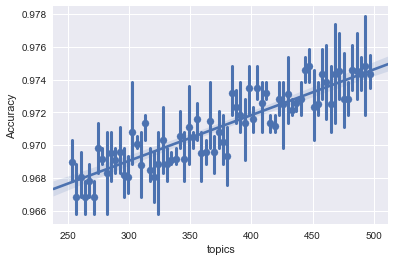

In [120]:
topics_frame = pd.DataFrame(topic_100_to_500)
topics_frame.columns = ['Accuracy','Precision','Recall','N-Size']
topics_frame['topics'] = range(250,501)

sns.regplot(
    x='topics',
    y='Accuracy',
    data = topics_frame[['topics','Accuracy']], 
    fit_reg=True,
    x_bins=70)

Tuning Conclusions:
- Stopwords: From the results above, the highest accuracy seems to occur when no stopwords are used. This is not surprising as the hypothesis tests seem to validate that spam text messages use more stopwords. This can be because spam messages generally include full sentences and grammatically correct structures in order to create readable messages that advertisers can get across to consumers. Because of this -- I will not use stopwords. 
- Number of Topics: 300 Seems to be a turning point and gains seem to cease after 400, thus 400 seems to be a good candidate. 

##### Tuned Model Results
Below I train the model above with improved parameter selection:
- 300 Topics
- Custom Stopwords
- No Symbols included

In [71]:
train_prepped_final = prep_nlp(
    data_to_prep = train.content,
    stop_words_in= stopwords_set2,
    symbols_to_remove=symbol_removed1)
built_model_final = build_model(
    train_data = train_prepped_final,
    topic_n = 300)
trained_model_final = train_model(
    topic_vec = built_model)


predicted_test_final = predict_unseen(
    new_doc_in=test,
    stop_words_in = stopwords_set2,
    symbols_to_remove = stopwords_set2,
    trained_model_in = trained_model_final)

performance_on_test_final = performance(
    result_x=predicted_test_final[0],
    result_y=predicted_test_final[1])

results_out_final = pd.DataFrame({
    'Test':performance_on_test_final
}).set_index(
    [['Accuracy','Precision','Recall','N Size'],
     ['% Spam / Ham Correct','% Predicted Spam Actually Spam','% Spam Detected','']])
results_out_final

,,Test
Accuracy,% Spam / Ham Correct,0.974506
Precision,% Predicted Spam Actually Spam,0.935673
Recall,% Spam Detected,0.846561
N Size,,1569.000000


#### 8. Confidence Interval for estimates

Question: What kind of accuracy, precision, and recall do we expect to see in future samples given that our text messages are acquired and do not differ from the 5000 text messages utilized here? 

Approach: Using resampling, resample 100 text messages 10,000 times. Use these to build a sampling distribution for Accuracy, Precision, and Recall that we will see with 90% liklihood in future cases. 



The two functions below:
    a. Samples 100 text messages and sorts them into the TFIDF, then predicts class membership
    b. Iterates the first point 10,000 in order to plot, 

In [72]:
def sample_predictions(sample_n):    
    predict_i = predict_unseen(new_doc_in=test.sample(sample_n), stop_words_in = stopwords_set2, symbols_to_remove = symbol_removed1,trained_model_in = trained_model_final)
    return performance(result_x=predict_i[0],result_y=predict_i[1]) 

    
def sample_predict_distributions(sample_n, iters):
    stats = [sample_predictions(sample_n) for i in range(iters)]
    return stats

sample_predictions_iterated = sample_predict_distributions(100,10000)

In [73]:
sampled_results_df = pd.DataFrame(sample_predictions_iterated)
sampled_results_df.columns = ['Accuracy','Precision','Recall','N-Size']
sampled_results_df = sampled_results_df

def ci_generate(measure):
    sampled_results_df[measure].plot(kind='hist')
    low,high, estimate = sampled_results_df[measure].quantile(.05),sampled_results_df[measure].quantile(.95),sampled_results_df[measure].mean()
    low_line = plt.plot([low, low], [0, 2500], 'k-', lw=1)
    high_line = plt.plot([high, high], [0, 2500], 'k-', lw=1)
    estimate_line = plt.plot([estimate,estimate],[0,2500],'k-',lw=1)
    return low_line, high_line, print('the 90% CI for ',measure,':',estimate,' is between ',low, ' and ', high,'. Where the measurement error is ',round(estimate-low,3))
    

##### Results
For the three metrics
- Accuracy has a range of .95 to 1
- Recall has a range of .66  to 1
- Precision has a range of .83 to 1

the 90% CI for  Accuracy : 0.9745705512009525  is between  0.95  and  1.0 . Where the measurement error is  0.025


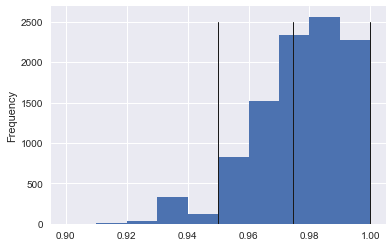

In [74]:
_ = ci_generate('Accuracy')

the 90% CI for  Recall : 0.845813539231293  is between  0.6666666666666666  and  1.0 . Where the measurement error is  0.179


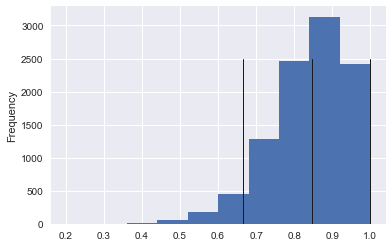

In [75]:
_ = ci_generate('Recall')

the 90% CI for  Precision : 0.9376853282931055  is between  0.8  and  1.0 . Where the measurement error is  0.138


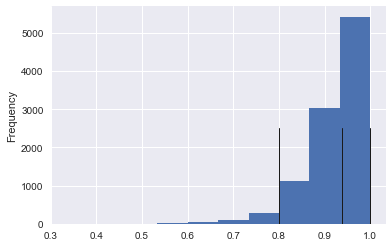

In [76]:
_ = ci_generate('Precision')